# LAMMPS 

In [1]:
import os 

In [1]:
from lammps import lammps
from comafunctions_Lammps import animate, preview_structure
import numpy as np
import time

In [2]:
lmp = lammps(cmdargs=['-sc', 'log']) 

## Initial Structure

In [3]:
preview_structure('crystalline_fcc.inp')

Number of structured atoms: 7776


JupyterViewportWidget(camera_params={'fov': 42.990374704158484, 'perspective': False, 'matrix': [[0.7071067811…

## LAMMPS Input Script
### https://docs.lammps.org/Commands_all.html

In [5]:
t_start = 1 #Kelvin
t_end = 1600 #Kelvin
timestep = 0.001
thermo = 200
steps = 30000
element = 'Al'

### Deformation Al

In [5]:
cmd = f'''
units metal
dimension 3
boundary p p p
atom_style atomic
read_data crystalline_fcc.inp
pair_style eam/alloy #adp
pair_coeff * * Al03.eam.alloy Al#Si_Au_Al.adp.txt Al Al Al

compute csym all centro/atom fcc
compute peratom all pe/atom

reset_timestep 0
timestep 0.001
velocity all create 300 12345 mom yes rot no
fix 1 all npt temp 300 300 1 iso 0 0 1 drag 1

thermo 1000

run 1000

unfix 1

reset_timestep 0

fix      1 all npt temp 300 300 1 y 0 0 1 z 0 0 1 drag 1
variable srate equal 1.0e10
variable srate1 equal "v_srate / 1.0e12"
fix      2 all deform 1 x erate 0.001 units box remap x #$[srate1]

dump     1 all cfg 20000 dump.tensile_*.cfg mass type xs ys zs c_csym c_peratom fx fy fz
#dump id all atom 50 dump2.lammpsstrj

thermo 1000

run 20000

'''

### Periodic Boundary Conditions Al Heating

In [5]:
cmd = f'''
units metal
dimension 3
boundary p p p
atom_style atomic
read_data crystalline_fcc.inp
pair_style eam/alloy #adp
pair_coeff * * Al03.eam.alloy Al#Si_Au_Al.adp.txt Al Al Al

timestep {timestep}

thermo {thermo}

thermo_style custom step temp vol press ke pe density 

variable s equal step
variable t equal temp
variable v equal vol
variable p equal press
variable k equal ke
variable P equal pe
variable d equal density
variable e equal etotal


fix thermo all print 200 '$s $t $v $p $k $P $d $e' file Output/thermo_output_{element}.dat screen no

velocity all create 1 589500 mom yes rot yes dist gaussian

dump 1 all custom 200 Output/dump_{element}.out id type xs ys zs

fix 2 all nvt temp {t_start} {t_end} 0.1

run {steps}

'''

### Non Periodic Boundary Conditions Al Heating

In [5]:
cmd = f'''

dimension 3
units metal
atom_style atomic
boundary p p p

read_data crystalline_fcc.inp

pair_style eam/alloy #adp
pair_coeff * * Al03.eam.alloy Al#Si_Au_Al.adp.txt Al Al Al

neighbor 3.0 bin

write_data original

change_box all x delta 0 3 
change_box all y delta 0 3 
change_box all z delta 0 3 boundary s s s

timestep {timestep}

thermo {thermo}

thermo_style custom step temp vol press ke pe density 

variable s equal step
variable t equal temp
variable v equal vol
variable p equal press
variable k equal ke
variable P equal pe
variable d equal density
variable e equal etotal


fix thermo all print 200 '$s $t $v $p $k $P $d $e' file Output/thermo_output_{element}.dat screen no

velocity all create 1 589500 mom yes rot yes dist gaussian

dump 1 all custom 200 Output/dump_{element}.out id type xs ys zs

fix 2 all nvt temp {t_start} {t_end} 0.1

run {steps}

#unfix 2

#fix 2 all nvt temp {t_end} {t_start} 0.1

#run 15000
       
'''

### Solid Phase Transfromation Ti Heating

In [5]:
cmd = f'''
dimension 3
units metal
atom_style atomic
boundary p p p
box tilt large

read_data Ti_Initial.txt

pair_style eam/alloy
pair_coeff * * Farkas_Nb-Ti-Al_1996.eam.alloy Ti

write_data original

timestep 0.001

fix ensemble all npt temp 1 1700 0.1 x 10.0 10.0 1.0 y 10.0 10.0 1.0 z 10.0 10.0 1.0 xy 0.0 0.0 1.0 xz 0.0 0.0 1.0 yz 0.0 0.0 1.0

velocity all create 1 589500 dist gaussian

dump 1 all custom 200 Output/dump_{element}.out id type xsu ysu zsu fx fy fz vx vy vz
dump_modify 1 sort id format line "%d %d %20.15g %20.15g %20.15g %20.15g %20.15g %20.15g %20.15g %20.15g %20.15g"
thermo_style custom step temp pe etotal vol
# thermo_style custom step temp pe etotal pxx pxy pxz pyy pyz pzz vol
thermo_modify format float %20.15g
thermo 200

variable t equal step
variable m equal temp
fix thermo all print 200 '$t $m' file thermo_output_{element}.dat screen no

run 60000

'''

In [7]:
start_time = time.time()

#Run the simulation
lmp.commands_string(cmd)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds")

Elapsed time: 1910.017048 seconds


In [6]:
animate(f'Output/dump_{element}.out',f'Output/thermo_output_{element}.dat')

Number of FCC atoms: 5780


AppLayout(children=(HTML(value='<h2>Animation of Results</h2>', layout=Layout(grid_area='header', height='5px'…

## Plotted Data

7


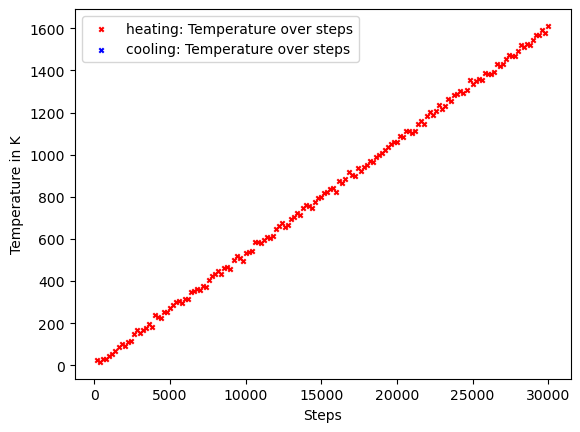

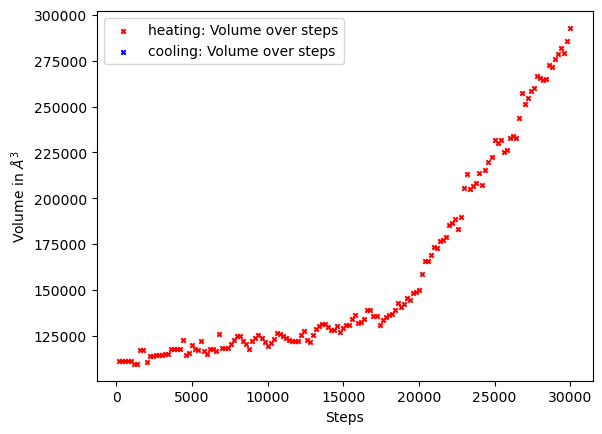

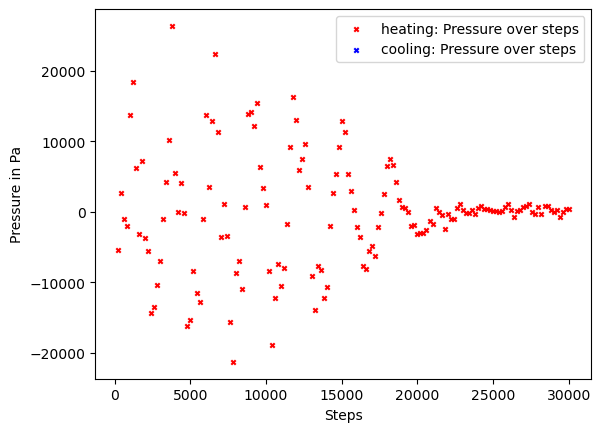

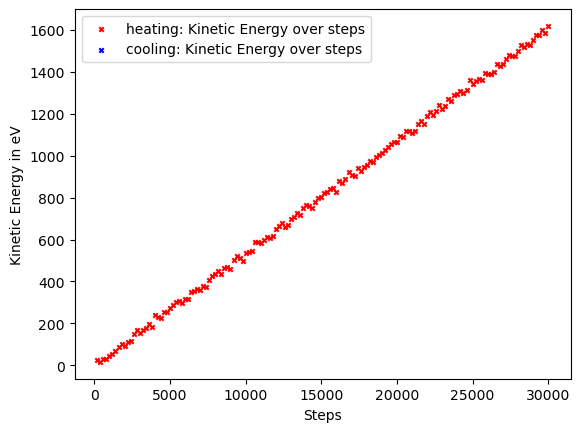

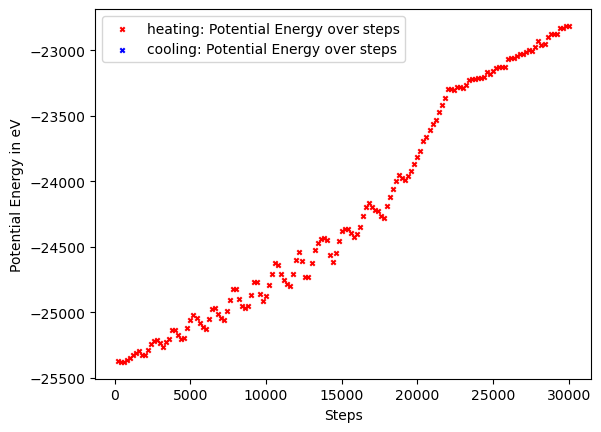

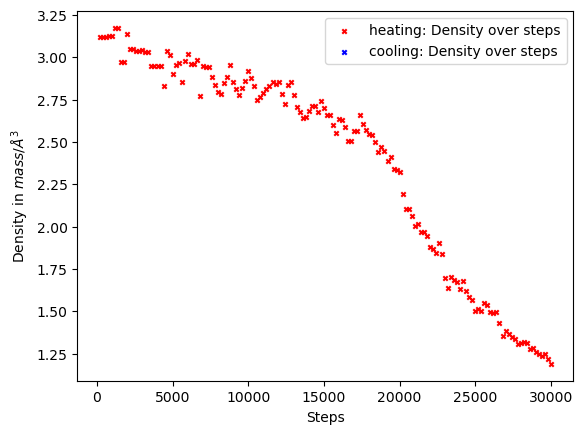

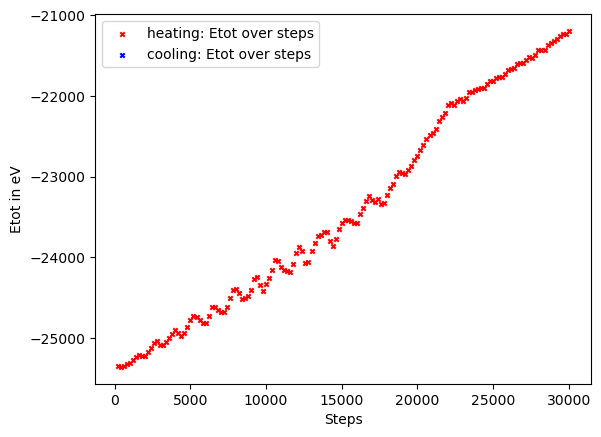

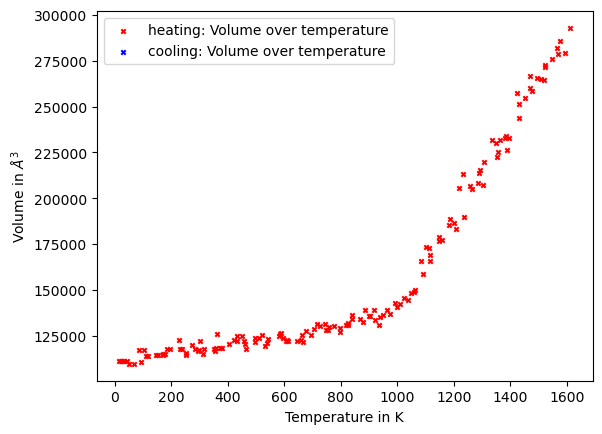

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv(f'thermo_output_{element}.dat', sep=" ",index_col=None, skiprows=1)

num_points_heating = int(steps/thermo)+1

s = data.iloc[:, 0]
t = data.iloc[:, 1]
v = data.iloc[:, 2]
p = data.iloc[:, 3]
ke = data.iloc[:, 4]
pe = data.iloc[:, 5]
d = data.iloc[:, 6]
e = data.iloc[:, 7]

variables = [t,v,p,ke,pe,d,e]

print(len(variables))
units = ['K', '$\AA^3$', 'Pa','eV','eV','$mass/\AA^3$','eV']
names = ['Temperature', 'Volume', 'Pressure', 'Kinetic Energy', 'Potential Energy','Density','Etot']

for i in range(0,len(variables)):
    plt.scatter(s[:num_points_heating],variables[i][:num_points_heating], label=f'heating: {names[i]} over steps', marker = 'x', color='r', s=10)
    plt.scatter(s[num_points_heating:],variables[i][num_points_heating:], label=f'cooling: {names[i]} over steps', marker = 'x', color='b', s=10)
    plt.ylabel(f'{names[i]} in {units[i]}')
    plt.xlabel('Steps')
    plt.legend()
    plt.show()
    
plt.scatter(t[:num_points_heating],v[:num_points_heating], label='heating: Volume over temperature', marker = 'x', color='r', s=10)
plt.scatter(t[num_points_heating:],v[num_points_heating:], label='cooling: Volume over temperature', marker = 'x', color='b', s=10)
plt.ylabel(f'Volume in $\AA^3$')
plt.xlabel('Temperature in K')
plt.legend()
plt.show()

### Heat Capacity
#### Mistake: Need to split the array into before and after Phasetransformation. Then create a fit for both of these parts and glue them back together before or after taking the derivative. 

In [8]:
p_heating = np.polyfit(t[:num_points_heating],e[:num_points_heating], 3)
#p_cooling = np.polyfit(t[num_points_heating:],e[num_points_heating:], 3)

# Create a poly1d object from the coefficients
f_heating = np.poly1d(p_heating)
#f_cooling = np.poly1d(p_cooling)

# Evaluate the function at 1000 points between 300 and 1358
xfine = np.linspace(1, 1600, 1000)
func_heating = f_heating(xfine)
#func_cooling = f_cooling(xfine)

# Take the derivative of the function
df_heating = f_heating.deriv()
#df_cooling = f_cooling.deriv()

# Evaluate the derivative at the same 1000 points
dfunc_heating = df_heating(xfine)
#dfunc_cooling = df_cooling(xfine)

# Print the results
print(f'Heating: f(T) = {f_heating}') 
print(f'Heating: df/dT = {df_heating}')
#print(f'Cooling: f(T) = {f_cooling}') 
#print(f'Cooling: df/dT = {df_cooling}')

Heating: f(T) =             3            2
-7.008e-07 x + 0.002208 x + 0.8539 x - 2.527e+04
Heating: df/dT =             2
-2.102e-06 x + 0.004415 x + 0.8539


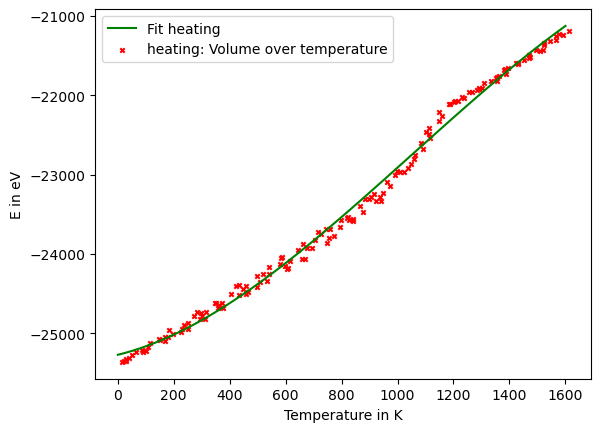

In [9]:
plt.scatter(t[:num_points_heating],e[:num_points_heating], label='heating: Volume over temperature', marker = 'x', color='r', s=10)
#plt.scatter(t[num_points_heating:],e[num_points_heating:], label='cooling: Volume over temperature', marker = 'x', color='b', s=10)
plt.plot(xfine,func_heating,label='Fit heating',c='g')
#plt.plot(xfine,func_cooling,label='Fit cooling',c='pink')
plt.ylabel(f'E in eV')
plt.xlabel('Temperature in K')
plt.legend()
plt.show()

In [8]:
## Split a list: Not done 

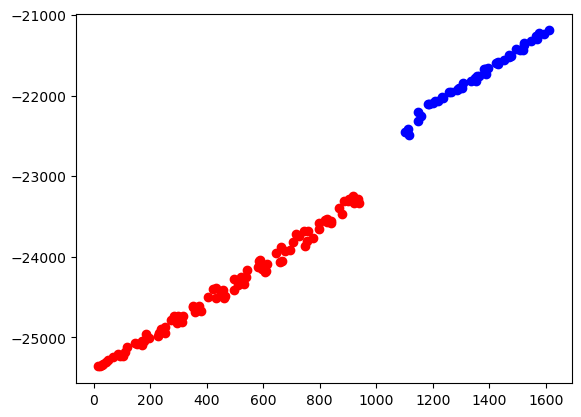

In [19]:
x,y = t[:num_points_heating],e[:num_points_heating]

# calculate the differences between adjacent points
diffs = [abs(y[i] - y[i+5]) for i in range(len(y)-5)]

# find the index of the point with the largest difference
max_diff_index = diffs.index(max(diffs))
x1, y1 = x[:max_diff_index+1], y[:max_diff_index+1]
x2, y2 = x[max_diff_index+15:], y[max_diff_index+15:]

# plot the two sets of points in different colors
plt.scatter(x1, y1, color='red')
plt.scatter(x2, y2, color='blue')

plt.show()

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
section1_x = np.array([point[0] for point in section1])
section1_y = np.array([point[1] for point in section1])
regressor = LinearRegression()
regressor.fit(section1_x.reshape(-1, 1), section1_y.reshape(-1, 1))
slope = regressor.coef_[0][0]
intercept = regressor.intercept_[0]


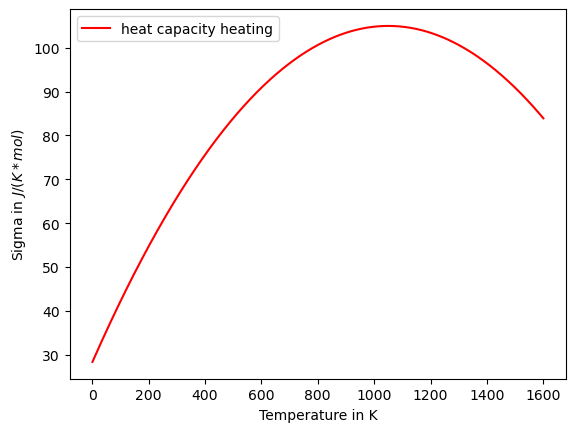

In [10]:
plt.plot(xfine,dfunc_heating*96485/2916,label='heat capacity heating', c='r')
#plt.plot(xfine,dfunc_cooling*96485/2916,label='heat capacity cooling', c='b')
data_heating = np.column_stack((xfine, dfunc_heating*96485/2916))
#data_cooling = np.column_stack((xfine, dfunc_cooling*96485/2916))
np.savetxt('Heat_Capacity_Heating.txt', data_heating)
#np.savetxt('Heat_Capacity_Cooling.txt',data_cooling)
plt.ylabel(f'Sigma in $J/(K*mol)$')
plt.xlabel('Temperature in K')
plt.legend()
plt.show()